https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

In [156]:
import numpy as np
from math import sqrt
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [157]:
def swap_columns(df, col1, col2):
    col_list = list(df.columns)
    x, y = col_list.index(col1), col_list.index(col2)
    col_list[y], col_list[x] = col_list[x], col_list[y]
    df = df[col_list]
    return df

In [158]:
df = read_csv('./Fog.csv')
df.drop(df.index[df[(df.values == 'X') | \
    (df.values == 'V')].index], inplace=True)
df = df.drop(['time','Label'],axis=1)
df = df.astype("float64")
df = swap_columns(df, 'VIZ', 'temp')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19659 entries, 0 to 19679
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   VIZ     19659 non-null  float64
 1   dpTemp  19659 non-null  float64
 2   RH      19659 non-null  float64
 3   WDIR    19659 non-null  float64
 4   temp    19659 non-null  float64
dtypes: float64(5)
memory usage: 921.5 KB


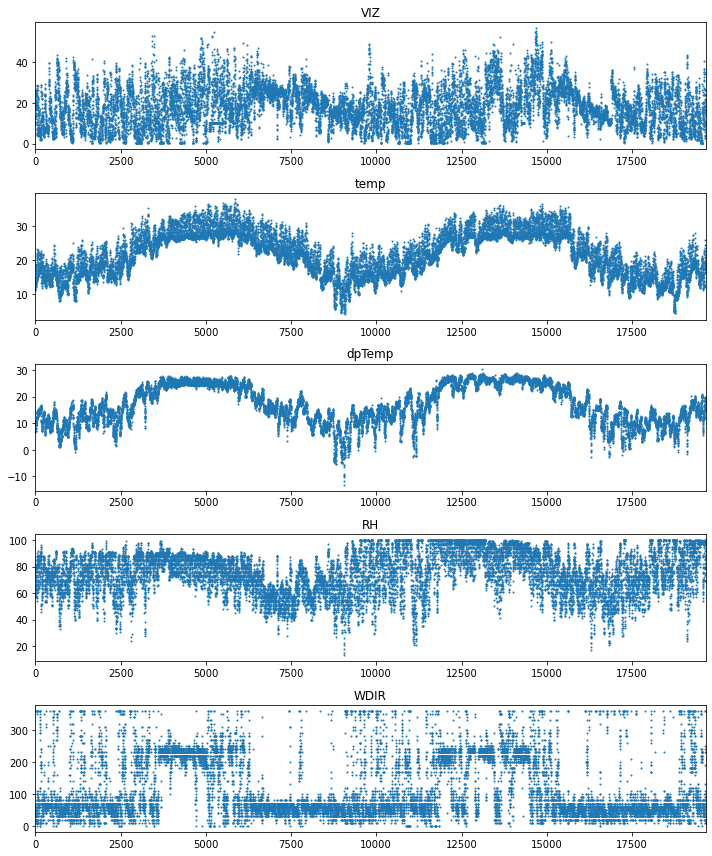

In [159]:
fig = pyplot.figure(figsize=(10, 12))

names = ('VIZ', 'temp', 'dpTemp', 'RH', 'WDIR')

for i in range(5):
    data = df[names[i]]
    ax = fig.add_subplot(5, 1, i + 1)
    pyplot.scatter(np.arange(data.size), data, s=1)
    ax.set_xlim([0, data.size])
    ax.set_title(names[i])

pyplot.tight_layout()
pyplot.show()

In [160]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [161]:
values = df.values
values = values.astype('float32')  # ensure all data is float
df

,VIZ,dpTemp,RH,WDIR,temp
0,10.51,6.7,73.0,60.0,11.4
1,9.94,6.8,74.0,50.0,11.3
2,9.89,6.9,74.0,30.0,11.4
3,10.41,6.8,74.0,40.0,11.3
4,11.99,7.0,74.0,50.0,11.5
...,...,...,...,...,...
19675,16.79,18.8,100.0,60.0,18.8
19676,18.52,18.2,97.0,40.0,18.7
19677,20.63,18.3,97.0,30.0,18.8
19678,15.93,18.3,98.0,10.0,18.6


In [162]:
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))  # Also try QuantileTransformer
scaled = scaler.fit_transform(values)
scaled

array([[0.18370579, 0.4572748 , 0.6896552 , 0.16666667, 0.21637425],
       [0.17367586, 0.45958427, 0.70114946, 0.1388889 , 0.21345031],
       [0.17279606, 0.46189374, 0.70114946, 0.08333334, 0.21637425],
       ...,
       [0.36178073, 0.7251731 , 0.9655173 , 0.08333334, 0.43274853],
       [0.27907798, 0.7251731 , 0.97701156, 0.02777778, 0.4269006 ],
       [0.15326412, 0.71131635, 0.97701156, 0.05555556, 0.40935674]],
      dtype=float32)

In [163]:
# frame as supervised learning
reframed = series_to_supervised(scaled,1 ,1)
reframed = reframed.drop(reframed.columns[[6, 7, 8, 9]], axis = 1)
print(reframed.head()) 

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)   var1(t)
1   0.183706   0.457275   0.689655   0.166667   0.216374  0.173676
2   0.173676   0.459584   0.701149   0.138889   0.213450  0.172796
3   0.172796   0.461894   0.701149   0.083333   0.216374  0.181946
4   0.181946   0.459584   0.701149   0.111111   0.213450  0.209748
5   0.209748   0.464203   0.701149   0.138889   0.219298  0.240366


In [164]:
reframed.shape

(19658, 6)

In [165]:
# split into train and test sets
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

In [166]:
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
train_X.shape

(8760, 5)

In [167]:
# reshape input to be 3D [samples, timesteps, features]
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X,(test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(8760, 1, 5) (8760,) (10898, 1, 5) (10898,)


Epoch 1/100
274/274 - 5s - loss: 0.0822 - val_loss: 0.0669 - 5s/epoch - 20ms/step
Epoch 2/100
274/274 - 3s - loss: 0.0467 - val_loss: 0.0620 - 3s/epoch - 11ms/step
Epoch 3/100
274/274 - 3s - loss: 0.0460 - val_loss: 0.0567 - 3s/epoch - 12ms/step
Epoch 4/100
274/274 - 3s - loss: 0.0465 - val_loss: 0.0531 - 3s/epoch - 12ms/step
Epoch 5/100
274/274 - 3s - loss: 0.0462 - val_loss: 0.0524 - 3s/epoch - 12ms/step
Epoch 6/100
274/274 - 3s - loss: 0.0459 - val_loss: 0.0510 - 3s/epoch - 13ms/step
Epoch 7/100
274/274 - 3s - loss: 0.0455 - val_loss: 0.0506 - 3s/epoch - 11ms/step
Epoch 8/100
274/274 - 3s - loss: 0.0455 - val_loss: 0.0505 - 3s/epoch - 12ms/step
Epoch 9/100
274/274 - 3s - loss: 0.0454 - val_loss: 0.0503 - 3s/epoch - 12ms/step
Epoch 10/100
274/274 - 3s - loss: 0.0454 - val_loss: 0.0502 - 3s/epoch - 12ms/step
Epoch 11/100
274/274 - 3s - loss: 0.0454 - val_loss: 0.0500 - 3s/epoch - 12ms/step
Epoch 12/100
274/274 - 3s - loss: 0.0453 - val_loss: 0.0493 - 3s/epoch - 12ms/step
Epoch 13/100


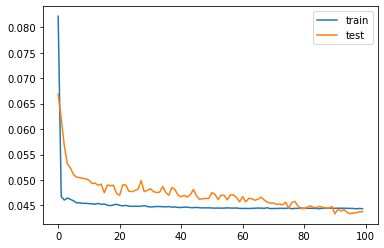

In [168]:
# design network
model = Sequential()
model.add(LSTM(64, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(32))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=100, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [185]:
# make a prediction
yhat = model.predict(test_X)
test_X = np.reshape(test_X(test_X.shape[0] , test_X.shape[2]))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = np.reshape(test_y(len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

ValueError: in user code:

    File "c:\ProgramData\Anaconda3\envs\tfenv\lib\site-packages\keras\engine\training.py", line 1801, in predict_function  *
        return step_function(self, iterator)
    File "c:\ProgramData\Anaconda3\envs\tfenv\lib\site-packages\keras\engine\training.py", line 1790, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\ProgramData\Anaconda3\envs\tfenv\lib\site-packages\keras\engine\training.py", line 1783, in run_step  **
        outputs = model.predict_step(data)
    File "c:\ProgramData\Anaconda3\envs\tfenv\lib\site-packages\keras\engine\training.py", line 1751, in predict_step
        return self(x, training=False)
    File "c:\ProgramData\Anaconda3\envs\tfenv\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\ProgramData\Anaconda3\envs\tfenv\lib\site-packages\keras\engine\input_spec.py", line 264, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "sequential_4" is incompatible with the layer: expected shape=(None, 1, 5), found shape=(None, 5)


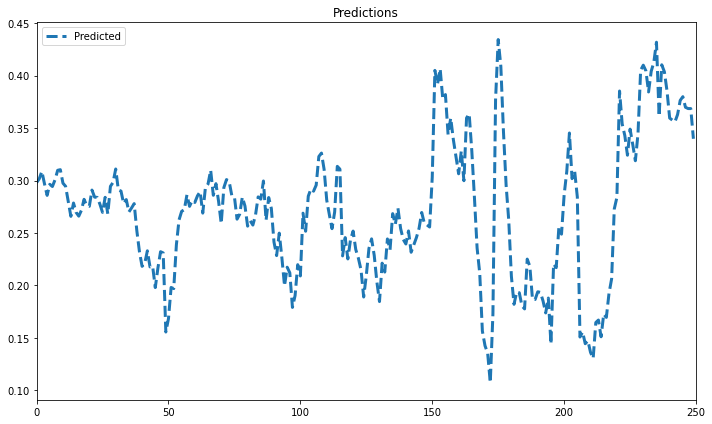

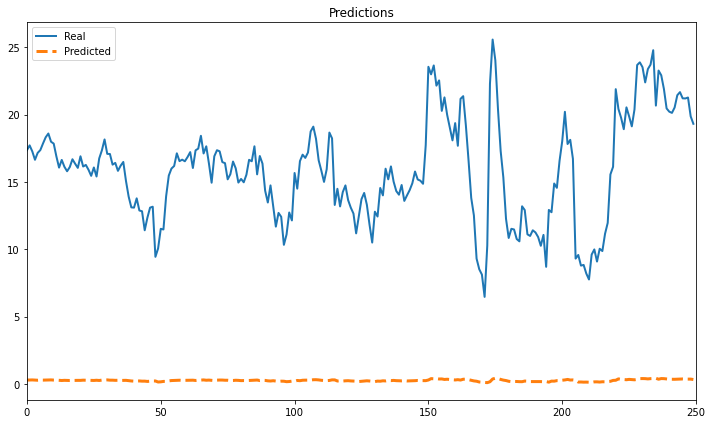

In [180]:
predicted = yhat.flatten()
dx = np.arange(predicted.size)

display_size = 250

pyplot.figure(figsize=(10, 6))
pyplot.title('Predictions')
pyplot.plot(dx[:display_size], predicted[:display_size],
         linestyle='--', linewidth=3, label='Predicted')
pyplot.xlim([0, display_size])
pyplot.legend()
pyplot.tight_layout()
pyplot.show()

pyplot.figure(figsize=(10, 6))
pyplot.title('Predictions')
pyplot.plot(dx[:display_size], inv_y[:display_size],linewidth=2, label='Real')
pyplot.plot(dx[:display_size], predicted[:display_size],
         linestyle='--', linewidth=3, label='Predicted')
pyplot.xlim([0, display_size])
pyplot.legend()
pyplot.tight_layout()
pyplot.show()